In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm, f, zscore, pointbiserialr, t
from sklearn.linear_model import LinearRegression
column_names = ["id", "Daerah", "SumbuUtama", "SumbuKecil", "Keunikan", "AreaBulatan", "Diameter", "KadarAir", "Keliling", "Bulatan", "Ransum", "Kelas"]
df = pd.read_csv("Gandum.csv", names=column_names, header=None) #asumsi gandum.csv disimpan di folder sama dengan .ipynb

In [4]:
def deskripsiStatistika(df, col_name):
    data = df[col_name]
    print("Analisis "+col_name+":")
    print("count    : "+str(data.count()))
    print("mean     : "+str(data.mean()))
    print("median   : "+str(data.median()))
    print("modus    : ", end="")
    if (len(data.mode()) == data.count()):
        print("NaN")
    else:
        print(str(data.mode()[0]), end="")
        start = True
        for m in data.mode():
            if (start):
                start = False
            else:
                print(", "+str(m), end="")
        print()
    print("stdev    : "+str(data.std()))
    print("variansi : "+str(data.var()))
    print("range    : "+str(data.max()-data.min()))
    print("max      : "+str(data.max()))
    print("min      : "+str(data.min()))
    print("25%      : "+str(data.quantile(0.25)))
    print("50%      : "+str(data.quantile(0.5)))
    print("75%      : "+str(data.quantile(0.75)))
    print("IQR      : "+str(data.quantile(0.75)-data.quantile(0.25)))
    print("skewness : "+str(data.skew()))
    print("kurtosis : "+str(data.kurt()))
        

In [5]:
def visualisasiData(df, col_name, showhist=True, showbox=True):
    if (showhist or showbox):
        data = df[col_name]
        nbins = int((data.count())**0.5+0.999) #ceiling dari akar jumlah data
        
        fig, axs = plt.subplots(ncols=int(showhist)+int(showbox), figsize=(10, 4))
        
        if (int(showhist)+int(showbox) == 1):
            axs = [axs]
        
        fig.suptitle("Visualisasi "+col_name)
        
        if (showhist):
            data.plot.hist(bins=nbins, ax=axs[0])
        if (showbox):
            bx = df.boxplot(column=[col_name], ax=axs[1])
            
        plt.show()

In [6]:
def tesDistribusiNormal(df, col_name):
    data = df[col_name]
    stat, p = shapiro(data) #shapiro-wilk test
    print("Tes normalitas "+col_name)
    print("w-statistic : "+str(stat))
    print("p-value     : "+str(p))
    print("\nP-value lebih ", end="")
    if (p > 0.05): #alpha 0.05 untuk confidence 95%
        print("besar", end="")
    else:
        print("kecil", end="")
    print(" dari 5%, hipotesis bahwa data berdistribusi normal ", end="")
    if (p > 0.05):
        print("gagal ", end="")
    print("ditolak.")
    
    visualisasiData(df, col_name, True, False)

In [7]:
def zTestMean(data, col_name, pStdev, miu0, h1=1):
    # 1. H0: µ = µ0
    h0 = None
    if (h1 == 1): # 2. H1: µ < µ0
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = (data.mean()-miu0)/(pStdev/(data.count()**0.5)) # z = (xbar - µ0)/(stdev/√n)
        text1 = "H0 "
        text2 = "ditolak. Rata-rata sample "+col_name
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal): # 5. z-test, z < -z_alpha
            text2 += " lebih kecil daripada "+str(miu0)
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "+str(miu0)
            decision += " tidak"
            h0 = True
        decision += " lebih kecil daripada nilai kritis = -"+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 2): # 2. H1: µ > µ0
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = (data.mean()-miu0)/(pStdev/(data.count()**0.5)) # z = (xbar - µ0)/(stdev/√n)
        text1 = "H0 "
        text2 = "ditolak. Rata-rata sample "+col_name
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore > critVal): # 5. z-test, z > z_alpha
            text2 += " lebih besar daripada "+str(miu0)
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "+str(miu0)
            decision += " tidak"
            h0 = True
        decision += " lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 3): # 2. H1: µ ≠ µ0
        sLevel = 0.975 # 3. alpha = 0.05, alpha/2 = 0.025
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_(alpha/2)
        zScore = (data.mean()-miu0)/(pStdev/(data.count()**0.5)) # z = (xbar - µ0)/(stdev/√n)
        text1 = "H0 "
        text2 = "ditolak. Rata-rata sample "+col_name
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal or zScore > critVal): # 5. z-test, z < -z_(alpha/2) atau z > z_(alpha/2)
            text2 += " tidak"
            h0 = False
        else:
            text1 += "tidak "
            decision += " tidak"
            h0 = True
        text2 += " sama dengan "+str(miu0)
        decision += " lebih kecil daripada minus nilai kritis = -"+('%5f'%critVal)+" atau lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    else:
        print("Bad H1 type")
        
    return h0

In [8]:
def zTestProportion(data, deskripsi, p, p0, h1=1):
    # 1. H0: p = p0
    h0 = None
    if (h1 == 1): # 2. H1: p < p0
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = (p-p0)/(((p0)*(1-p0)/data.count())**0.5) # z = (p-p0)/(√p0q0/n)
        text1 = "H0 "
        text2 = "ditolak. Proporsi "+deskripsi+" di sample"
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal): # 5. z-test, z < -z_alpha
            text2 += " lebih kecil daripada "+str(p0)
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "+str(p0)
            decision += " tidak"
            h0 = True
        decision += " lebih kecil daripada nilai kritis = -"+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 2): # 2. H1: p > p0
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = (p-p0)/(((p0)*(1-p0)/data.count())**0.5) # z = (p-p0)/(√p0q0/n)
        text1 = "H0 "
        text2 = "ditolak. Proporsi "+deskripsi+" di sample"
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore > critVal): # 5. z-test, z > z_alpha
            text2 += " lebih besar daripada "+str(p0)
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "+str(p0)
            decision += " tidak"
            h0 = True
        decision += " lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 3): # 2. H1: p ≠ p0
        sLevel = 0.975 # 3. alpha = 0.05, alpha/2 = 0.025
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_(alpha/2)
        zScore = (p-p0)/(((p0)*(1-p0)/data.count())**0.5) # z = (p-p0)/(√p0q0/n)
        text1 = "H0 "
        text2 = "ditolak. Proporsi "+deskripsi+" di sample"
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal or zScore > critVal): # 5. z-test, z < -z_(alpha/2) atau z > z_(alpha/2)
            text2 += " tidak"
            h0 = False
        else:
            text1 += "tidak "
            decision += " tidak"
            h0 = True
        text2 += " sama dengan "+str(p0)
        decision += " lebih kecil daripada minus nilai kritis = -"+('%5f'%critVal)+" atau lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    else:
        print("Bad H1 type")
    
    return h0

In [9]:
def zTestMean2(data1, data2, col_name, pStdev1, pStdev2, d0, h1=1):
    # 1. H0: µ1 - µ2 = d0
    h0 = None
    if (h1 == 1): # 2. H1: µ1 - µ2 < d0
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = ((data1.mean()-data2.mean())-d0)/(((pStdev1**2)/data1.count()+(pStdev2**2)/data2.count())**0.5) # z = ((xbar1-xbar2)-d0)/(√((var1/n1)+(var2/n2)))
        text1 = "H0 "
        text2 = "ditolak. Selisih rata-rata sample 1 dengan sample 2 dari "+col_name
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal): # 5. z-test, z < -z_alpha
            text2 += " lebih kecil dari "
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "
            decision += " tidak"
            h0 = True
        text2 += str(d0)
        decision += " lebih kecil daripada nilai kritis = -"+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 2): # 2. H1: µ1 - µ2 > d0
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = ((data1.mean()-data2.mean())-d0)/(((pStdev1**2)/data1.count()+(pStdev2**2)/data2.count())**0.5) # z = ((xbar1-xbar2)-d0)/(√((var1/n1)+(var2/n2)))
        text1 = "H0 "
        text2 = "ditolak. Selisih rata-rata sample 1 dengan sample 2 dari "+col_name
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore > critVal): # 5. z-test, z > z_alpha
            text2 += " lebih besar dari "
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "
            decision += " tidak"
            h0 = True
        text2 += str(d0)
        decision += " lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 3): # 2. H1: µ1 - µ2 ≠ d0
        sLevel = 0.975 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_(alpha/2)
        zScore = ((data1.mean()-data2.mean())-d0)/(((pStdev1**2)/data1.count()+(pStdev2**2)/data2.count())**0.5) # z = ((xbar1-xbar2)-d0)/(√((var1/n1)+(var2/n2)))
        text1 = "H0 "
        text2 = "ditolak. Selisih rata-rata sample 1 dengan sample 2 dari "+col_name
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal or zScore > critVal): # 5. z-test, z < -z_(alpha/2) or z > z_(alpha/2)
            text2 += " tidak"
            h0 = False
        else:
            text1 += "tidak "
            decision += " tidak"
            h0 = True
        text2 += " sama dengan "+str(d0)
        decision += " lebih kecil daripada minus nilai kritis = -"+('%5f'%critVal)+" atau lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    else:
        print("Bad H1 type")
    
    return h0

In [10]:
def zTestProportion2(data1, data2, deskripsi, x1, x2, h1=1):
    # 1. H0: µ1 - µ2 = d0
    h0 = None
    p = (x1+x2)/(data1.count()+data2.count())
    p1 = x1/data1.count()
    p2 = x2/data2.count()
    if (h1 == 1): # 2. H1: p1 < p2
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = (p1-p2)/((p*(1-p)*(1/data1.count()+1/data2.count()))**0.5) # z = (p1-p2)/(pq(1/n1+1/n2))
        text1 = "H0 "
        text2 = "ditolak. Proporsi "+deskripsi+" di sample 1"
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal): # 5. z-test, z < -z_alpha
            text2 += " lebih kecil dari "
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "
            decision += " tidak"
            h0 = True
        text2 += "proporsi nilai yang sama di sample 2"
        decision += " lebih kecil daripada nilai kritis = -"+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 2): # 2. H1: p1 > p2
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_alpha
        zScore = (p1-p2)/((p*(1-p)*(1/data1.count()+1/data2.count()))**0.5) # z = (p1-p2)/(pq(1/n1+1/n2))
        text1 = "H0 "
        text2 = "ditolak. Proporsi "+deskripsi+" di sample 1"
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore > critVal): # 5. z-test, z > z_alpha
            text2 += " lebih besar dari "
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "
            decision += " tidak"
            h0 = True
        text2 += "proporsi nilai yang sama di sample 2"
        decision += " lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 3): # 2. H1: p1 ≠ p2
        sLevel = 0.975 # 3. alpha = 0.05, alpha/2 = 0.025
        critVal = norm.ppf(sLevel) # 4. z-test, critical value = z_(alpha/2)
        zScore = (p1-p2)/((p*(1-p)*(1/data1.count()+1/data2.count()))**0.5) # z = (p1-p2)/(pq(1/n1+1/n2))
        text1 = "H0 "
        text2 = "ditolak. Proporsi "+deskripsi+" di sample 1"
        decision = "Karena z = "+('%5f'%zScore)
        if (zScore < -critVal or zScore > critVal): # 5. z-test, z < -z_(alpha/2) or z > z_(alpha/2)
            text2 += " tidak"
            h0 = False
        else:
            text1 += "tidak "
            decision += " tidak"
            h0 = True
        text2 += " sama dengan proporsi nilai yang sama di sample 2"
        decision += " lebih kecil daripada minus nilai kritis = -"+('%5f'%critVal)+" atau lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    else:
        print("Bad H1 type")
    
    return h0

In [11]:
def fTestVariance2(data1, data2, col_name, h1=1):
    # 1. H0: µ1 - µ2 = d0
    h0 = None
    n1 = data1.count()
    n2 = data2.count()
    var1 = data1.var()
    var2 = data2.var()
    if (h1 == 1): # 2. H1: s1^2 < s2^2
        sLevel = 0.975 # 3. alpha = 0.05, alpha/2 = 0.025
        critVal = f.ppf(sLevel, n1, n2) # 4. f-test, critical value = f_(1-alpha/2) dengan df1 = n1, df2 = n2
        fScore = var1/var2 # f = s1^2/s2^2
        text1 = "H0 "
        text2 = "ditolak. Variansi sample 1"
        decision = "Karena f = "+('%5f'%fScore)
        if (fScore < -critVal): # 5. f-test, f < -f_(alpha/2) (v1, v2)
            text2 += " lebih kecil dari "
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "
            decision += " tidak"
            h0 = True
        text2 += "variansi sample 2"
        decision += " lebih kecil daripada nilai kritis = -"+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 2): # 2. H1: s1^2 > s2^2
        sLevel = 0.95 # 3. alpha = 0.05
        critVal = f.ppf(sLevel, n1, n2) # 4. f-test, critical value = f_(1-alpha/2) dengan df1 = n1, df2 = n2
        fScore = var1/var2 # f = s1^2/s2^2
        text1 = "H0 "
        text2 = "ditolak. Variansi sample 1"
        decision = "Karena z = "+('%5f'%zScore)
        if (fScore > critVal): # 5. 5. f-test, f > f_(alpha/2) (v1, v2)
            text2 += " lebih besar dari "
            h0 = False
        else:
            text1 += "tidak "
            text2 += " sama dengan "
            decision += " tidak"
            h0 = True
        text2 += "variansi sample 2"
        decision += " lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    elif (h1 == 3): # 2. H1: s1^2 ≠ s2^2
        sLevel = 0.975 # 3. alpha = 0.05, alpha/2 = 0.025
        critVal = f.ppf(sLevel, n1, n2) # 4. f-test, critical value = f_(1-alpha/2) dengan df1 = n1, df2 = n2
        fScore = var1/var2 # f = s1^2/s2^2
        text1 = "H0 "
        text2 = "ditolak. Variansi sample 1"
        decision = "Karena z = "+('%5f'%fScore)
        if (fScore < -critVal or fScore > critVal): # 5. f-test, f < -f_(alpha/2) (v1, v2) atau f > f_(alpha/2) (v1, v2)
            text2 += " tidak"
            h0 = False
        else:
            text1 += "tidak "
            decision += " tidak"
            h0 = True
        text2 += " sama dengan variansi sample 2"
        decision += " lebih kecil daripada minus nilai kritis = -"+('%5f'%critVal)+" atau lebih besar daripada nilai kritis = "+('%5f'%critVal)+", "
        print(decision, end="")
        print(text1+text2) # 6. Ambil keputusan
    else:
        print("Bad H1 type")
    
    return h0

In [29]:
def correlationTestBinary(df, col_name1, col_name2):
    df2 = df[[col_name1, col_name2]].copy()
    df2 = df2[(np.abs(zscore(df2)) < 3).all(axis=1)].copy() # menghapus outlier menggunakan metode menganggap data dengan selisih 3 standar deviasi dari rata-rata sebagai outlier
    corrVal, pVal = pointbiserialr(df2[col_name2]-np.ones(df2[col_name2].count()), df2[col_name1])
    print("Nilai korelasi "+col_name1+" dengan "+col_name2+" adalah "+('%5f'%corrVal), end="")
    if (corrVal < 0):
        print(", yaitu korelasi negatif", end="")
    else:
        print(", yaitu korelasi positif", end="")
    if (np.abs(corrVal) > 0.7):
        print(" yang kuat")
    elif (np.abs(corrVal) < 0.17):
        print(" yang sangat lemah")
    elif (np.abs(corrVal) < 0.3):
        print(" yang lemah")
    
    X = df2[[col_name2]]
    y = df2[[col_name1]]
    
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    plt.scatter(X, y, color = "red")
    plt.plot(X, regressor.predict(X), color = "blue")
    plt.title("Scatter plot "+col_name1+" terhadap "+col_name2)
    plt.xlabel(col_name2)
    plt.ylabel('mark2')
    plt.show()

In [30]:
# 1.
for col_name in column_names:
    deskripsiStatistika(df, col_name)
    print()

Analisis id:
count    : 500
mean     : 250.5
median   : 250.5
modus    : NaN
stdev    : 144.4818327679989
variansi : 20875.0
range    : 499
max      : 500
min      : 1
25%      : 125.75
50%      : 250.5
75%      : 375.25
IQR      : 249.5
skewness : 0.0
kurtosis : -1.2000000000000002

Analisis Daerah:
count    : 500
mean     : 4801.246
median   : 4735.0
modus    : 3992, 4881, 5642, 6083
stdev    : 986.3954914816018
variansi : 972976.0656152307
range    : 4931
max      : 7453
min      : 2522
25%      : 4042.75
50%      : 4735.0
75%      : 5495.5
IQR      : 1452.75
skewness : 0.23814408738280812
kurtosis : -0.4346305340273977

Analisis SumbuUtama:
count    : 500
mean     : 116.04517136778003
median   : 115.40513994999999
modus    : NaN
stdev    : 18.28262595755936
variansi : 334.25441190402336
range    : 153.79546865999998
max      : 227.9285827
min      : 74.13311404
25%      : 104.11609817499999
50%      : 115.40513994999999
75%      : 129.046792025
IQR      : 24.93069385000001
skewness

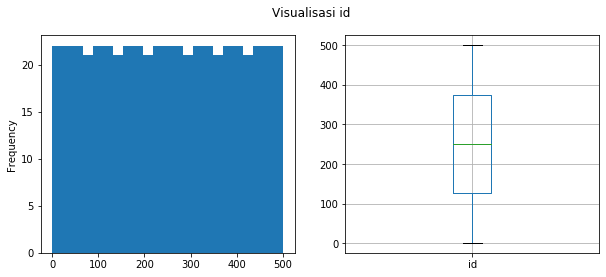

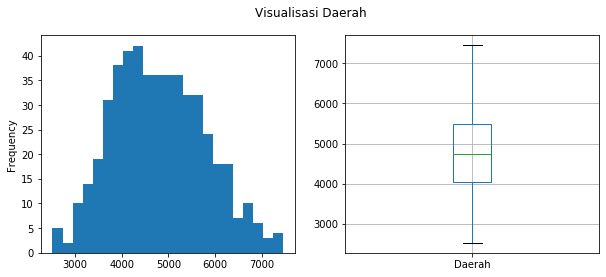

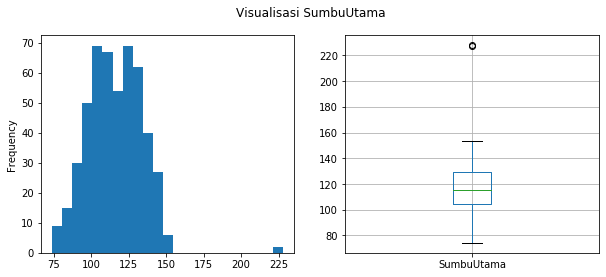

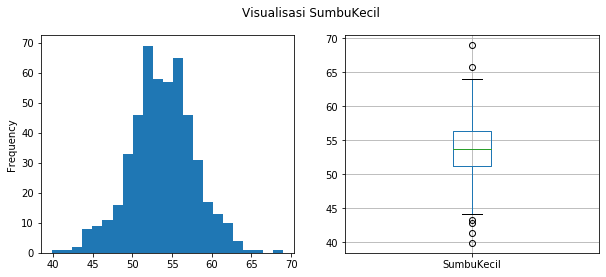

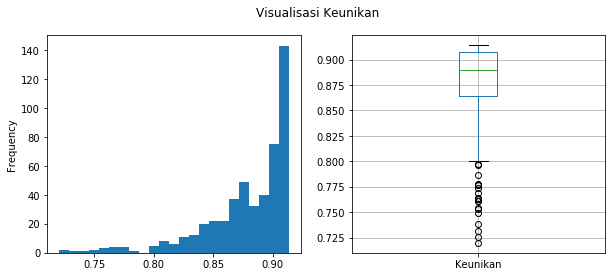

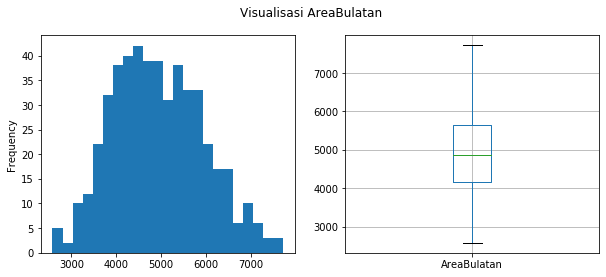

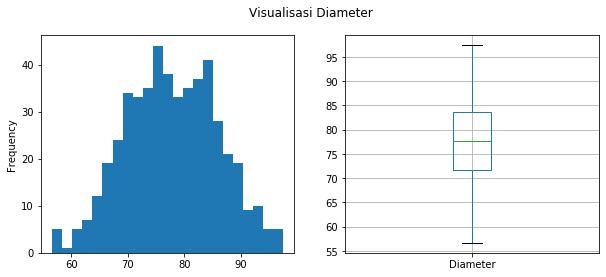

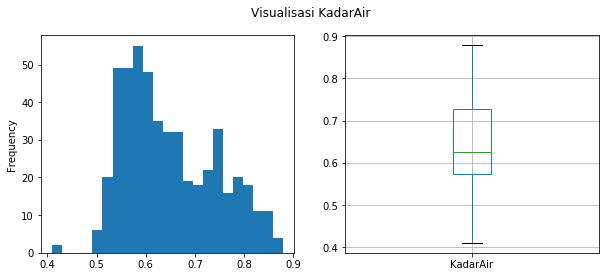

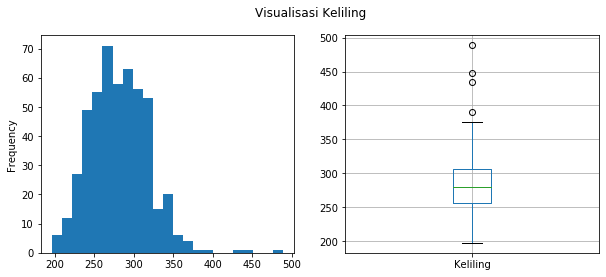

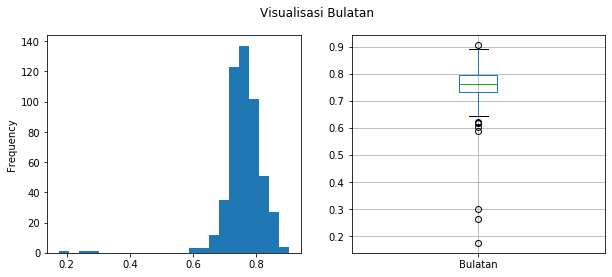

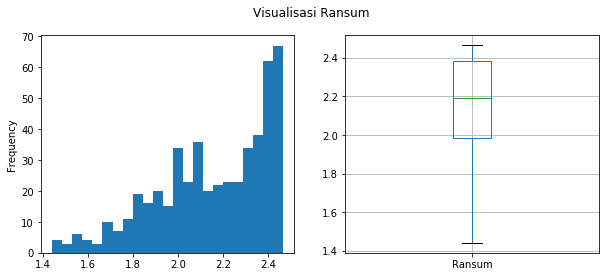

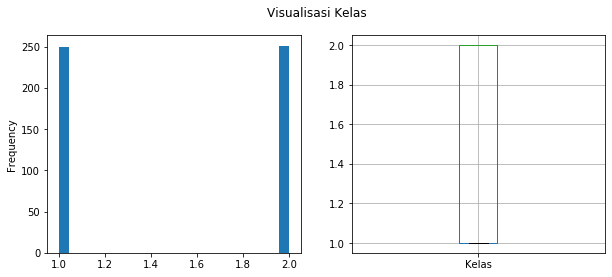

In [14]:
# 2.
for col_name in column_names:
    visualisasiData(df, col_name)

Tes normalitas id
w-statistic : 0.9547221064567566
p-value     : 2.945410582100294e-11

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


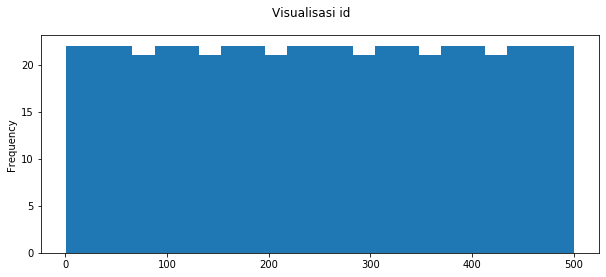


Tes normalitas Daerah
w-statistic : 0.9907860159873962
p-value     : 0.003270698245614767

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


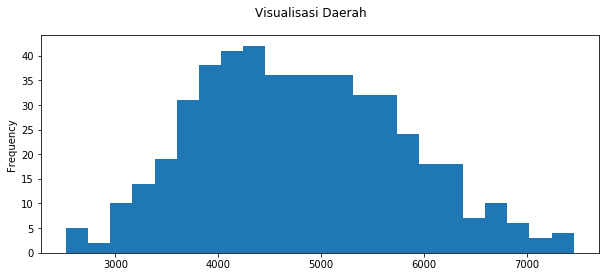


Tes normalitas SumbuUtama
w-statistic : 0.9513812065124512
p-value     : 9.236201213569384e-12

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


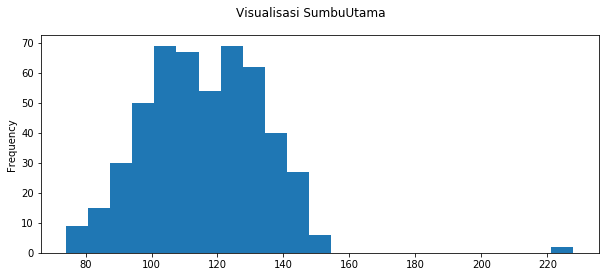


Tes normalitas SumbuKecil
w-statistic : 0.996778666973114
p-value     : 0.4234558641910553

P-value lebih besar dari 5%, hipotesis bahwa data berdistribusi normal gagal ditolak.


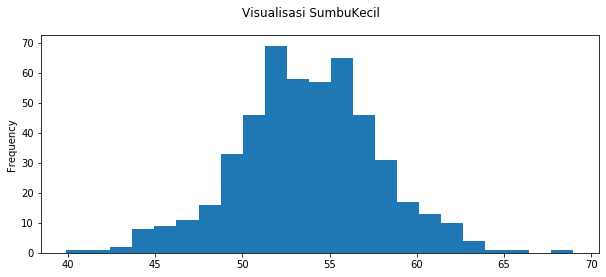


Tes normalitas Keunikan
w-statistic : 0.8309029340744019
p-value     : 1.3151663082081454e-22

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


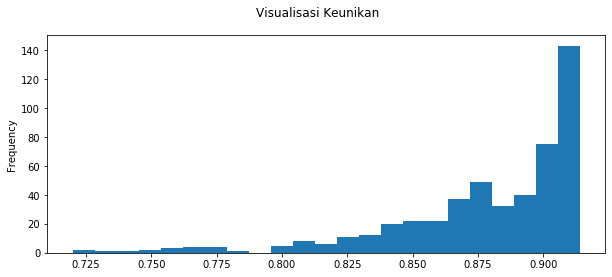


Tes normalitas AreaBulatan
w-statistic : 0.990435779094696
p-value     : 0.0024847122840583324

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


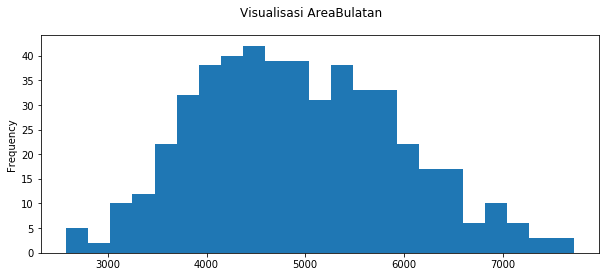


Tes normalitas Diameter
w-statistic : 0.9951366186141968
p-value     : 0.11834503710269928

P-value lebih besar dari 5%, hipotesis bahwa data berdistribusi normal gagal ditolak.


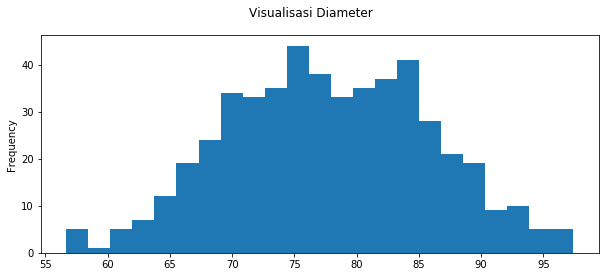


Tes normalitas KadarAir
w-statistic : 0.9466671347618103
p-value     : 1.959499836695633e-12

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


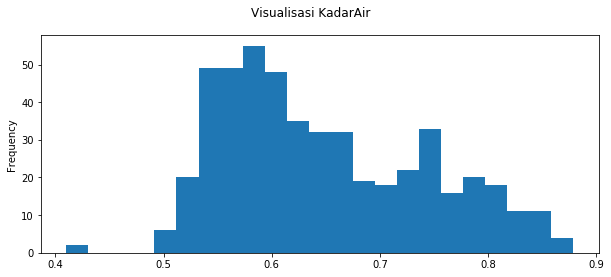


Tes normalitas Keliling
w-statistic : 0.9692449569702148
p-value     : 9.728394090302572e-09

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


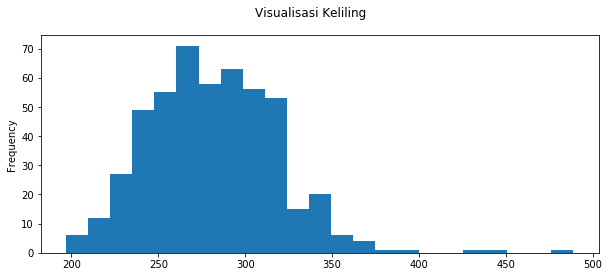


Tes normalitas Bulatan
w-statistic : 0.7697757482528687
p-value     : 6.899158691421287e-26

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


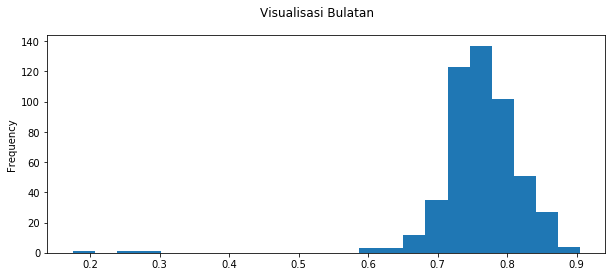


Tes normalitas Ransum
w-statistic : 0.9265043139457703
p-value     : 6.245541108888591e-15

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


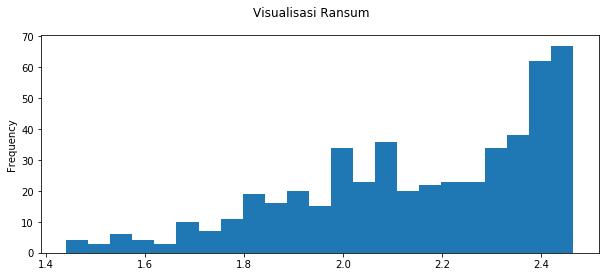


Tes normalitas Kelas
w-statistic : 0.6365421414375305
p-value     : 3.5514183439331154e-31

P-value lebih kecil dari 5%, hipotesis bahwa data berdistribusi normal ditolak.


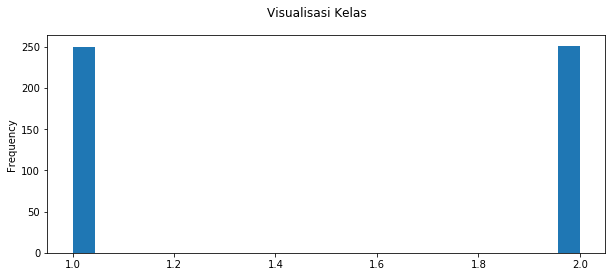

In [15]:
# 3.
for col_name in column_names:
    tesDistribusiNormal(df, col_name)
    print()

In [16]:
# 4. Karena data diperlakukan sebagai populasi, untuk setiap test, standar deviasi populasi diketahui;
#    yakni z-test dapat digunakan
# 4.a.
data = df["Daerah"].sample(frac=0.5, replace=False, random_state=1)
zTestMean(data, "Daerah", df["Daerah"].std(), 4700, 2)
print()
# 4.b.
data = df["SumbuUtama"].sample(frac=0.5, replace=False, random_state=1)
zTestMean(data, "SumbuUtama", df["SumbuUtama"].std(), 116, 3)
print()
# 4.c.
data = df["SumbuKecil"].head(20)
zTestMean(data, "SumbuKecil", df["SumbuKecil"].std(), 50, 3)
print()
# 4.d.
data = df["Diameter"].sample(frac=0.5, replace=False, random_state=1)
x = 0
for each in data:
    if (each > 85):
        x += 1
x /= data.count()
zTestProportion(data, "nilai Diameter yang lebih dari 85", x, 0.15, 3)
print()
# 4.e.
data = df["Keliling"].sample(frac=0.5, replace=False, random_state=1)
x = 0
for each in data:
    if (each < 100):
        x += 1
x /= data.count()
zTestProportion(data, "nilai Keliling yang kurang dari 100", x, 0.05, 1)

Karena z = 2.241816 lebih besar daripada nilai kritis = 1.644854, H0 ditolak. Rata-rata sample Daerah lebih besar daripada 4700

Karena z = 0.281245 tidak lebih kecil daripada minus nilai kritis = -1.959964 atau lebih besar daripada nilai kritis = 1.959964, H0 tidak ditolak. Rata-rata sample SumbuUtama sama dengan 116

Karena z = 5.368745 lebih kecil daripada minus nilai kritis = -1.959964 atau lebih besar daripada nilai kritis = 1.959964, H0 ditolak. Rata-rata sample SumbuKecil tidak sama dengan 50

Karena z = 3.099652 lebih kecil daripada minus nilai kritis = -1.959964 atau lebih besar daripada nilai kritis = 1.959964, H0 ditolak. Proporsi nilai Diameter yang lebih dari 85 di sample tidak sama dengan 0.15

Karena z = -3.627381 lebih kecil daripada nilai kritis = -1.644854, H0 ditolak. Proporsi nilai Keliling yang kurang dari 100 di sample lebih kecil daripada 0.05


False

In [17]:
# 5. Karena data diperlakukan sebagai populasi, untuk setiap test, standar deviasi populasi diketahui;
#    yakni z-test dapat digunakan
# 5.a.
n = df["AreaBulatan"].count()
stdev = df["AreaBulatan"].std()
data1 = df["AreaBulatan"].head(n//2)
data2 = df["AreaBulatan"].tail(int(n/2+0.5))
zTestMean2(data1, data2, "AreaBulatan", stdev, stdev, 0, 3)
print()
# 5.b.
n = df["KadarAir"].count()
stdev = df["KadarAir"].std()
data1 = df["KadarAir"].head(n//2)
data2 = df["KadarAir"].tail(int(n/2+0.5))
zTestMean2(data1, data2, "KadarAir", stdev, stdev, 0.2, 2)
print()
# 5.c.
n = df["Bulatan"].count()
stdev = df["Bulatan"].std()
data1 = df["Bulatan"].head(20)
data2 = df["Bulatan"].tail(20)
zTestMean2(data1, data2, "Bulatan", stdev, stdev, 0, 3)
print()
# 5.d.
n = df["Ransum"].count()
data1 = df["Ransum"].head(n//2)
data2 = df["Ransum"].tail(int(n/2+0.5))
x1 = 0
x2 = 0
for each in data1:
    if (each > 2):
        x1 += 1
for each in data2:
    if (each > 2):
        x2 += 1
zTestProportion2(data1, data2, "nilai Ransum yang lebih dari 2", x1, x2, 2)
print()
# 5.e.
n = df["Diameter"].count()
data1 = df["Diameter"].head(n//2)
data2 = df["Diameter"].tail(int(n/2+0.5))
fTestVariance2(data1, data2, "Diameter", 3)

Karena z = 13.543236 lebih kecil daripada minus nilai kritis = -1.959964 atau lebih besar daripada nilai kritis = 1.959964, H0 ditolak. Selisih rata-rata sample 1 dengan sample 2 dari AreaBulatan tidak sama dengan 0

Karena z = -26.687732 tidak lebih besar daripada nilai kritis = 1.644854, H0 tidak ditolak. Selisih rata-rata sample 1 dengan sample 2 dari KadarAir sama dengan 0.2

Karena z = -1.526601 tidak lebih kecil daripada minus nilai kritis = -1.959964 atau lebih besar daripada nilai kritis = 1.959964, H0 tidak ditolak. Selisih rata-rata sample 1 dengan sample 2 dari Bulatan sama dengan 0

Karena z = 13.397486 lebih besar daripada nilai kritis = 1.644854, H0 ditolak. Proporsi nilai Ransum yang lebih dari 2 di sample 1 lebih besar dari proporsi nilai yang sama di sample 2

Karena z = 1.083878 tidak lebih kecil daripada minus nilai kritis = -1.282081 atau lebih besar daripada nilai kritis = 1.282081, H0 tidak ditolak. Variansi sample 1 sama dengan variansi sample 2


True

Nilai korelasi Daerah dengan Kelas adalah -0.602747, yaitu korelasi negatif

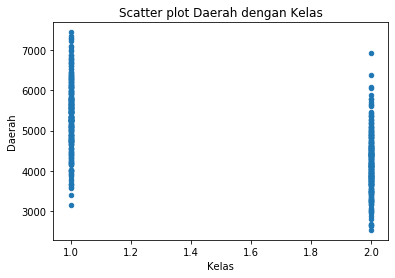

Nilai korelasi SumbuUtama dengan Kelas adalah -0.748103, yaitu korelasi negatif yang kuat


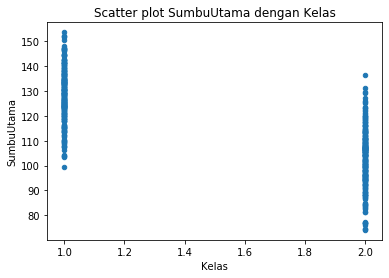

Nilai korelasi SumbuKecil dengan Kelas adalah -0.166094, yaitu korelasi negatif yang sangat lemah


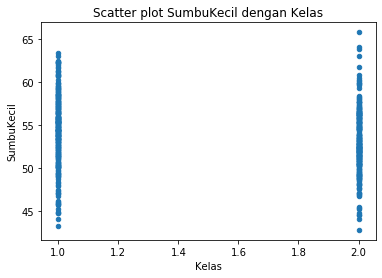

Nilai korelasi Keunikan dengan Kelas adalah -0.791628, yaitu korelasi negatif yang kuat


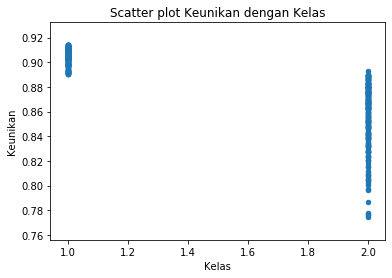

Nilai korelasi AreaBulatan dengan Kelas adalah -0.607313, yaitu korelasi negatif

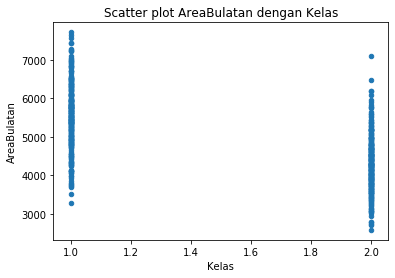

Nilai korelasi Diameter dengan Kelas adalah -0.602536, yaitu korelasi negatif

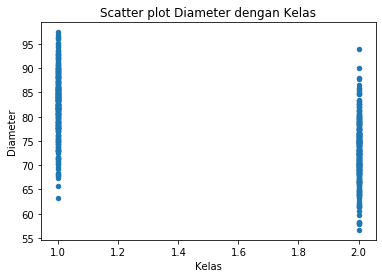

Nilai korelasi KadarAir dengan Kelas adalah 0.134344, yaitu korelasi positif yang sangat lemah


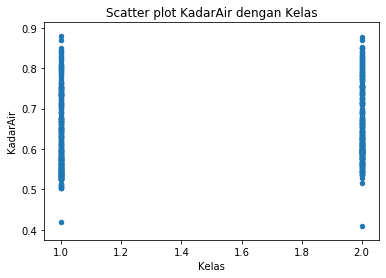

Nilai korelasi Keliling dengan Kelas adalah -0.678458, yaitu korelasi negatif

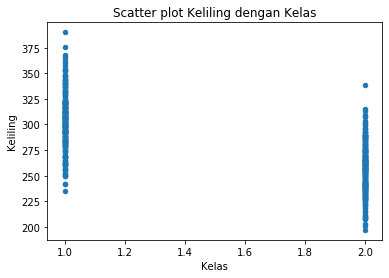

Nilai korelasi Bulatan dengan Kelas adalah 0.706467, yaitu korelasi positif yang kuat


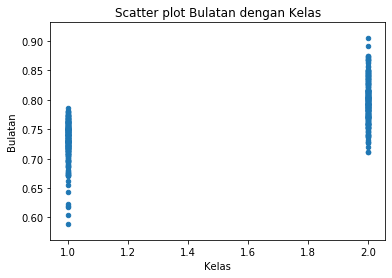

In [31]:
for col_name in column_names[1:-2]:
    correlationTestBinary(df, col_name, "Kelas")

Nilai korelasi A dengan B adalah 0.991915, yaitu korelasi positif yang kuat, namun karena nilai p-value 1.123279632533771e-89, korelasi antara A dengan B tidak linier


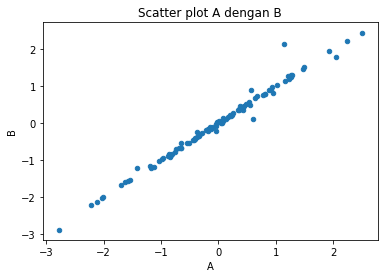

In [21]:
rr = np.random.randn(100)
rredit = [rr[i]+((-1)**i)/(i+1) for i in range(len(rr))]
dat = [[rr[i], rredit[i]] for i in range(len(rr))]
df2 = pd.DataFrame(dat, columns=["A", "B"])
correlationTestBinary(df2, "A", "B")